# Define a Multi-cathode system

This guide describes how to set up an exemplary multi-cathode system programmatically.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysimtra as ps

**Note: before starting, make sure that the SIMTRA application was imported into pySIMTRA**

If not done, use the following method which copies the SIMTRA executable (and some other files crucial for the execution) into the package folder. This only needs to be done ONCE. Calling this method later again will replace the already existing copied files.

In [2]:
# Define the path to the SIMTRA application folder
sim_path = 'C:/Users/Felix/Desktop/simtra_v2.2'
# Import the application into the package
ps.import_exe(sim_path)

## Set up the chamber

The `Chamber` object holds general information about the environment like the temperature and pressure. Either a cylindrical or rectangular chamber can be defined. All units in SIMTRA are SI units. Here we will create a cylindrical chamber with a radius of 120 mm and length of 180 mm.

In [3]:
# Create a cylindrical sputter chamber
ch = ps.Chamber.cylindrical(radius=0.12, length=0.18, temperature=293, pressure=0.5)

## Set up the magnetrons

The `Magnetron` object holds further parameters of the deposition, like the transported element and the number of particles to simulate. Its geometry is defined via a `DummyObject`, which needs to be built from individual surfaces. Here, we use the same standard axialsymmetric magnetron with a circular target as for the single-cathode system. The only difference is that they will be arranged on a circle and tilted inwards by 10° as with a typical co-sputter setup. The racetracks are taken from the racetrack database which can be found on [GitHub](https://github.com/felixthln/pysimtra).

In [10]:
# Construct the magnetron will be identical to the example of the single-cathode system
target = ps.Circle(name='target', radius=0.0191, position=(0, 0, 0.055))
shield = ps.Cone(name='shield', small_rho=0.0191, big_rho=0.023, height=0.005, position=(0, 0, 0.055))
cap = ps.Circle(name='cap', radius=0.03, position=(0, 0, 0.06))
cap.perforate(by='circle', radius=0.023)
body = ps.Cylinder(name='body', radius=0.03, height=0.06)
# Define the elements and ion energies to use (depends on the power supply)
e_ion = {'Ni': 54, 'Ru': 262, 'Pt': 305, 'Pd': 270}
# The chamber will have four cathodes positioned on an "anker circle" and with an identical tilt
cat_pos = {'Ni': 45, 'Ru': 135, 'Pt': -135, 'Pd': -45}  # °
r_anker, cat_tilt = 0.06, 10  # m, °
# Create a magnetron for each element
mags: list[ps.Magnetron] = []
for i, elem in enumerate(e_ion.keys(), 1):
    # Calculate the position (in m) and orientation (in °)
    pos = np.cos(np.radians(cat_pos[elem])) * r_anker, np.sin(np.radians(cat_pos[elem])) * r_anker, 0
    orien = cat_pos[elem], -cat_tilt, 0
    # Create the dummy object from the surfaces
    m_object = ps.DummyObject(name='mag_%d' % i, surfaces=[target, shield, cap, body], position=pos, orientation=orien)
    # Define a path to the racetrack file
    r_path = 'racetracks/%s_racetrack_1.5_inch.txt' % elem
    # Construct the magnetron
    mag = ps.Magnetron(transported_element=elem, m_object=m_object, n_particles=10**8, 
                       sputter_surface_index=1, racetrack_file_path=r_path, max_ion_energy=e_ion[elem])
    # Store the new magnetron to assign it later to the sputter system
    mags.append(mag)

## Set up the dummy object(s)

`DummyObject`s are objects without emitting a particle flux. Instead, they allow to track the number of particles hitting their surface. That is why we will define a `DummyObject` to track the number of particles sputtered onto an exemplary substrate. The tracking of the particles can be enabled by setting `save_avg_data=True` and providing an averaging grid by setting `avg_grid`. In this case, the substrate only consists of a single surface. The dummy object defined here is also identical to the one used for the single-cathode system.

In [5]:
# Define the size of the substrate (this is reused later when plotting the results)
s_dx, s_dy = 0.05, 0.05
# Create a rectangle to track the particles arrival
s_surf = ps.Rectangle(name='subSurface', dx=s_dx, dy=s_dy, save_avg_data=True, avg_grid=(200, 100))
# Wrap the rectangle into a dummy object
sub = ps.DummyObject(name='substrate', surfaces=[s_surf], position=(0, 0, 0.15))

## Define the sputter system

Finally, the `SputterSystem` can be defined from the `Chamber`, `Magnetron` and `DummyObject`(s). Additionally, an output path needs to be provided, to which the simulation results will be saved. Instead of passing only one magnetron, now a list of `Magnetrons` needs to be passed.

In [6]:
# Define an output path for the simulation
out_path = 'C:/Users/Felix/Desktop/sim_result'
# Creating the sputter system is identical to a single-cathode system, just pass a list of magnetrons rather than a single one
system = ps.SputterSystem(ch, mags, sub, out_path)

## Saving the sputter system

Also a `SputterSystem` with multiple magnetrons can be exported, but this needs to be done to multiple ".sin" files since a single file can only hold one magnetron. When doing that, the remaining magnetrons are automatically converted to `DummyObjects`, so they are still considered in the simulation.

In [7]:
# Save sputter system with the first magnetron as a sin file. In the cell above we defined the first magnetron as "mag_1", therefore this name needs to 
# be used
system.to_sin(path='C:/Users/Felix/Desktop/res.sin', mag_name='mag_1')

## Perform a simulation and plot the results

To perform a simulation, only the `simulate()` method needs to be called. As the package is based on a Windows executable, **this part only works on Windows operating systems**. This is powered by multithreading and depending on the number of cores of your CPU, the simulations are run in parallel. 

In [8]:
# Start the simulation
results = system.simulate()
# Alternatively, by passing a list to the optional parameter "magnetrons", a subset of magnetrons can be simulated, e.g.
# results = system.simulate(magnetrons=['mag_2', 'mag_4'])

Plotting the results is also very similar to the single-magnetron system. There will be one `SimtraOutput` object per magnetron. The order is identical to the order of the list provided when the `SputterSystem` object was created. When the `magnetrons` paramater was used when the simulation was started, the order of outputs corresponds to the order of magnetron names passed to this parameter. 

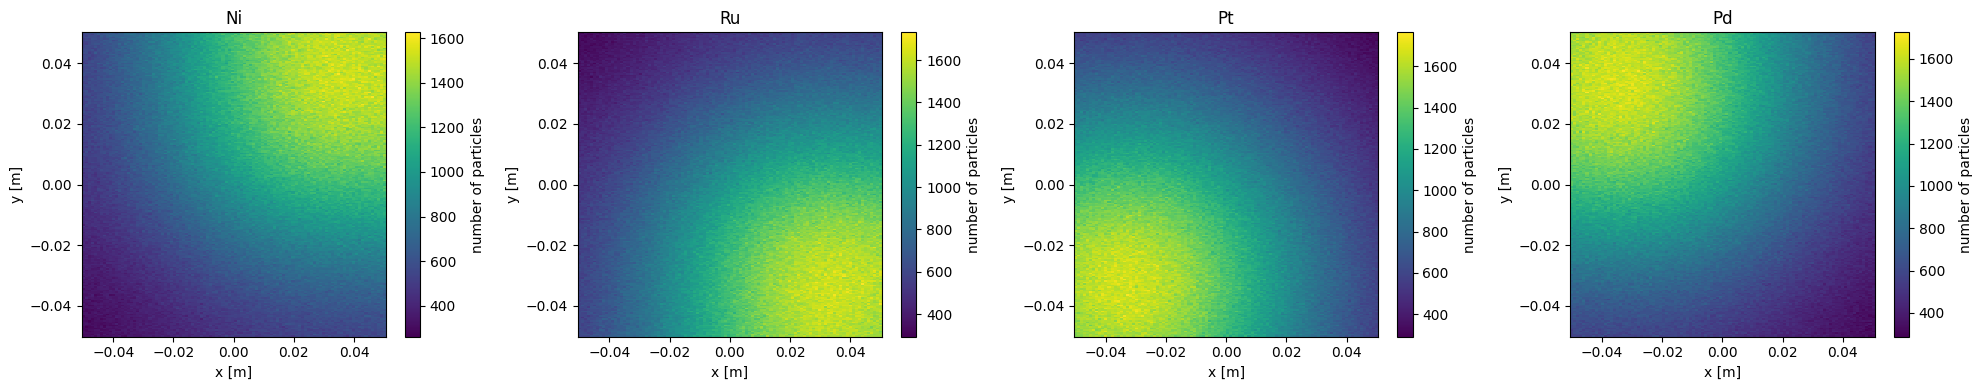

In [9]:
# Create a plot with as many subplots as there are outputs
fig, ax = plt.subplots(1, len(results), figsize=(len(results) * 5, 4))

# Iterate over the elements and load plot simulation result
for i, elem in enumerate(e_ion.keys()):
    # Get the number of particles sputtered onto the substrate identical to the single-magnetron system
    n_p = results[i].n_particles['substrate']
    # Create a meshgrid for also displaying x and y values (also identical)
    x = np.linspace(-s_dx, s_dx, n_p.shape[1])
    y = np.linspace(-s_dx, s_dx, n_p.shape[0])
    X, Y = np.meshgrid(x, y)
    # Plot the particle distribution
    pc = ax[i].pcolormesh(X, Y, n_p)
    # Add axes labels
    ax[i].set_xlabel('x [m]')
    ax[i].set_ylabel('y [m]')
    # Add a title showing the sputtered elements
    ax[i].set_title(elem)
    # Add a colorbar
    fig.colorbar(pc, ax=ax[i], label='number of particles')

# Adjust layout and show the plot
fig.tight_layout()
plt.show()

This section showed how a multi-cathode sputter system can be defined. To learn more about the used classed and methods, see the API reference section.